In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import contractions
import re

In [2]:
data = pd.read_csv('Autonomous_Driving_Tweets.csv', encoding='latin1')

In [3]:
data.head()

,chatgpt_data_id,twitter_id,typename,user_rest_id,user_name,user_screen_name,user_followers_count,user_url,full_text,favorite_count,bookmark_count,reply_count,retweet_count,quote_count,lang,created_at,keyword,date_start,date_end,is_retweet
0,781753,1815534826159779922,Tweet,537778485,International Daily News,mggjrb,7263,https://pbs.twimg.com/profile_banners/53777848...,"On Qingdao Zhongshan Road, a silver-gray drive...",1,0,0,0,0,en,Mon Jul 22 23:50:08 +0000 2024,NaN,Driverless Car,until:2024-07-23 since:2024-06-23,NaN
1,781754,1815534769121423808,Tweet,879124379451351041,Amazing Qingdao,QingdaoAmazing,14166,https://pbs.twimg.com/profile_banners/87912437...,"On Qingdao Zhongshan Road, a silver-gray drive...",1,0,0,1,0,en,Mon Jul 22 23:49:54 +0000 2024,NaN,Driverless Car,until:2024-07-23 since:2024-06-23,NaN
2,781755,1815533426952261976,Tweet,1543154052371922944,Hon Hai International,zhouguoqing2188,152,https://pbs.twimg.com/profile_banners/15431540...,"@elonmusk Brother Ma, does your Tesla driverle...",0,0,2,0,0,en,Mon Jul 22 23:44:34 +0000 2024,NaN,Driverless Car,until:2024-07-23 since:2024-06-23,NaN
3,781758,1815493523640340979,Tweet,952170209955098624,Mr. Hello,Hello_Yar_,744,NaN,"@visualfeastwang Wow, Driverless car_ China is...",5,0,0,0,0,en,Mon Jul 22 21:06:00 +0000 2024,NaN,Driverless Car,until:2024-07-23 since:2024-06-23,NaN
4,781759,1815493125298667594,Tweet,1811099070896738304,Time Traveler,time_travel_now,105,https://pbs.twimg.com/profile_banners/18110990...,"@Kling_ai Translation: In 2028, the driverless...",0,0,1,0,0,en,Mon Jul 22 21:04:25 +0000 2024,NaN,Driverless Car,until:2024-07-23 since:2024-06-23,NaN


In [4]:
data.columns

Index(['chatgpt_data_id', 'twitter_id', 'typename', 'user_rest_id',
       'user_name', 'user_screen_name', 'user_followers_count', 'user_url',
       'full_text', 'favorite_count', 'bookmark_count', 'reply_count',
       'retweet_count', 'quote_count', 'lang', 'created_at', 'keyword',
       'date_start', 'date_end', 'is_retweet'],
      dtype='object')

In [5]:
data.shape

(50386, 20)

In [6]:
data = data[data['lang'] == 'en'][['created_at', 'full_text']]
data = data.rename(columns={'created_at': 'time', 'full_text': 'text'})

In [7]:
data = data.drop_duplicates()

data = data.reset_index(drop=True)

data.head()

,time,text
0,Mon Jul 22 23:50:08 +0000 2024,"On Qingdao Zhongshan Road, a silver-gray drive..."
1,Mon Jul 22 23:49:54 +0000 2024,"On Qingdao Zhongshan Road, a silver-gray drive..."
2,Mon Jul 22 23:44:34 +0000 2024,"@elonmusk Brother Ma, does your Tesla driverle..."
3,Mon Jul 22 21:06:00 +0000 2024,"@visualfeastwang Wow, Driverless car_ China is..."
4,Mon Jul 22 21:04:25 +0000 2024,"@Kling_ai Translation: In 2028, the driverless..."


In [8]:
data.shape

(45713, 2)

In [9]:
# Helper functions for preprocessing
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):  # ADJECTIVE
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):  # VERB
        return wordnet.VERB
    elif nltk_tag.startswith('N'):  # NOUN
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):  # ADVERB
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [10]:
def preprocess_text(text):
    if isinstance(text, float):  # Handle NaN or empty values
        text = ""
    # Expand contractions
    text = contractions.fix(text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove hashtags and mentions
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove punctuation, numbers, and special characters
    text = re.sub(r'[^a-zA-Z\s#@]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize text
    words = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    lemmatized_text = lemmatize_sentence(' '.join(words))
    return lemmatized_text

In [11]:
data['processed_text'] = data['text'].apply(preprocess_text)

In [12]:
data.head()

,time,text,processed_text
0,Mon Jul 22 23:50:08 +0000 2024,"On Qingdao Zhongshan Road, a silver-gray drive...",qingdao zhongshan road silvergray driverless c...
1,Mon Jul 22 23:49:54 +0000 2024,"On Qingdao Zhongshan Road, a silver-gray drive...",qingdao zhongshan road silvergray driverless c...
2,Mon Jul 22 23:44:34 +0000 2024,"@elonmusk Brother Ma, does your Tesla driverle...",brother tesla driverless car support core paym...
3,Mon Jul 22 21:06:00 +0000 2024,"@visualfeastwang Wow, Driverless car_ China is...",wow driverless car china work next level aur y...
4,Mon Jul 22 21:04:25 +0000 2024,"@Kling_ai Translation: In 2028, the driverless...",translation driverless car enter united state ...


In [13]:
from textblob import TextBlob

# Perform sentiment analysis and classify
def analyze_sentiment(text):
    if isinstance(text, float):  # Handle empty or NaN values
        return 0.0
    return TextBlob(text).sentiment.polarity

# Add sentiment scores to the dataset
data['textblob_score'] = data['processed_text'].apply(analyze_sentiment)

In [14]:
# Categorize sentiment based on the score
def classify_sentiment(score):
    if score < -0.1:
        return 'negative'
    elif -0.1 <= score <= 0.1:
        return 'neutral'
    else:
        return 'positive'

data['textblob_label'] = data['textblob_score'].apply(classify_sentiment)

In [15]:
data['textblob_label'].value_counts()

textblob_label
neutral     19748
positive    17868
negative     8097
Name: count, dtype: int64

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

In [17]:
# Perform sentiment analysis using VADER and classify
def analyze_vader_sentiment(text):
    if isinstance(text, float):  # Handle empty or NaN values
        return 0.0
    return vader_analyzer.polarity_scores(text)['compound']

# Add VADER sentiment scores to the dataset
data['VADER_score'] = data['processed_text'].apply(analyze_vader_sentiment)

In [18]:
# Categorize sentiment based on the VADER score
def classify_vader_sentiment(score):
    if score < -0.1:
        return 'negative'
    elif -0.1 <= score <= 0.1:
        return 'neutral'
    else:
        return 'positive'

data['VADER_label'] = data['VADER_score'].apply(classify_vader_sentiment)

In [19]:
data['VADER_label'].value_counts()

VADER_label
positive    19823
negative    17297
neutral      8593
Name: count, dtype: int64

In [20]:
# Calculate the average of TextBlob and VADER scores
data['combined_score'] = data[['textblob_score', 'VADER_score']].mean(axis=1)

In [21]:
# Categorize sentiment based on the combined score
def classify_combined_sentiment(score):
    if score < -0.1:
        return 'negative'
    elif -0.1 <= score <= 0.1:
        return 'neutral'
    else:
        return 'positive'

data['label'] = data['combined_score'].apply(classify_combined_sentiment)

In [22]:
# Count the occurrences of each label
data['label'].value_counts()

label
positive    20320
negative    15336
neutral     10057
Name: count, dtype: int64

In [23]:
from datetime import datetime

# Convert 'time' column to ISO 8601 format without timezone
def convert_to_iso8601(date_str):
    try:
        # Parse the original format
        parsed_date = datetime.strptime(date_str, '%a %b %d %H:%M:%S %z %Y')
        # Convert to ISO 8601 format without timezone
        return parsed_date.strftime('%Y-%m-%dT%H:%M:%S')
    except ValueError:
        return None  # Handle invalid dates gracefully

data['time'] = data['time'].apply(convert_to_iso8601)

In [24]:
data

,time,text,processed_text,textblob_score,textblob_label,VADER_score,VADER_label,combined_score,label
0,2024-07-22T23:50:08,"On Qingdao Zhongshan Road, a silver-gray drive...",qingdao zhongshan road silvergray driverless c...,-0.050000,neutral,0.0000,neutral,-0.025000,neutral
1,2024-07-22T23:49:54,"On Qingdao Zhongshan Road, a silver-gray drive...",qingdao zhongshan road silvergray driverless c...,-0.050000,neutral,0.0000,neutral,-0.025000,neutral
2,2024-07-22T23:44:34,"@elonmusk Brother Ma, does your Tesla driverle...",brother tesla driverless car support core paym...,0.000000,neutral,0.4019,positive,0.200950,positive
3,2024-07-22T21:06:00,"@visualfeastwang Wow, Driverless car_ China is...",wow driverless car china work next level aur y...,0.050000,neutral,0.8126,positive,0.431300,positive
4,2024-07-22T21:04:25,"@Kling_ai Translation: In 2028, the driverless...",translation driverless car enter united state ...,0.104167,positive,0.0258,neutral,0.064983,neutral
...,...,...,...,...,...,...,...,...,...
45708,2024-09-26T17:26:25,@CollinRugg I've been saying it for years now....,say year read graffiti wall say read graffiti ...,0.358333,positive,0.4404,positive,0.399367,positive
45709,2024-09-28T22:50:08,@Tazerface16 He lied about his cars¡¯ self-dri...,lied car selfdriving year ago people buy car t...,0.000000,neutral,-0.6705,negative,-0.335250,negative
45710,2024-09-28T22:42:52,@WholeMarsBlog A self driving car with no stea...,self drive car stearing wheel whatever importa...,0.400000,positive,0.2023,positive,0.301150,positive
45711,2024-09-28T22:38:15,Big news for Waymo! The self-driving car pione...,big news waymo selfdriving car pioneer expand ...,0.050000,neutral,0.3182,positive,0.184100,positive


In [25]:
import matplotlib.pyplot as plt

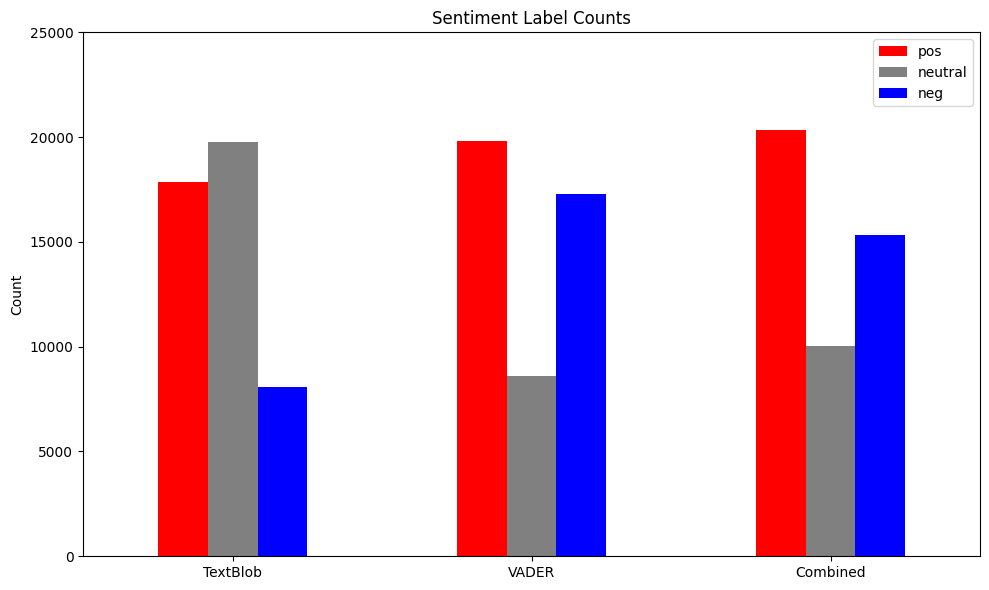

In [26]:
# Count the label occurrences for each method
textblob_counts = data['textblob_label'].value_counts().reindex(['positive', 'neutral', 'negative'], fill_value=0)
vader_counts = data['VADER_label'].value_counts().reindex(['positive', 'neutral', 'negative'], fill_value=0)
combined_counts = data['label'].value_counts().reindex(['positive', 'neutral', 'negative'], fill_value=0)

# Combine the counts into a DataFrame for plotting
counts_df = pd.DataFrame({
    'TextBlob': textblob_counts,
    'VADER': vader_counts,
    'Combined': combined_counts
}).T

# Plotting
labels = ['positive', 'neutral', 'negative']
colors = ['red', 'gray', 'blue']  # Use specified colors
counts_df.plot(kind='bar', color=colors, figsize=(10, 6))

# Customizing the plot
plt.xticks(range(len(counts_df)), ['TextBlob', 'VADER', 'Combined'], rotation=0)
plt.yticks(range(0, counts_df.values.max() + 5000, 5000), labels=range(0, counts_df.values.max() + 5000, 5000))
plt.ylabel('Count')
plt.title('Sentiment Label Counts')
plt.legend(['pos', 'neutral', 'neg'], loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10788\3019719183.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['week'] = filtered_data['time'].dt.to_period('W').apply(lambda r: r.start_time)


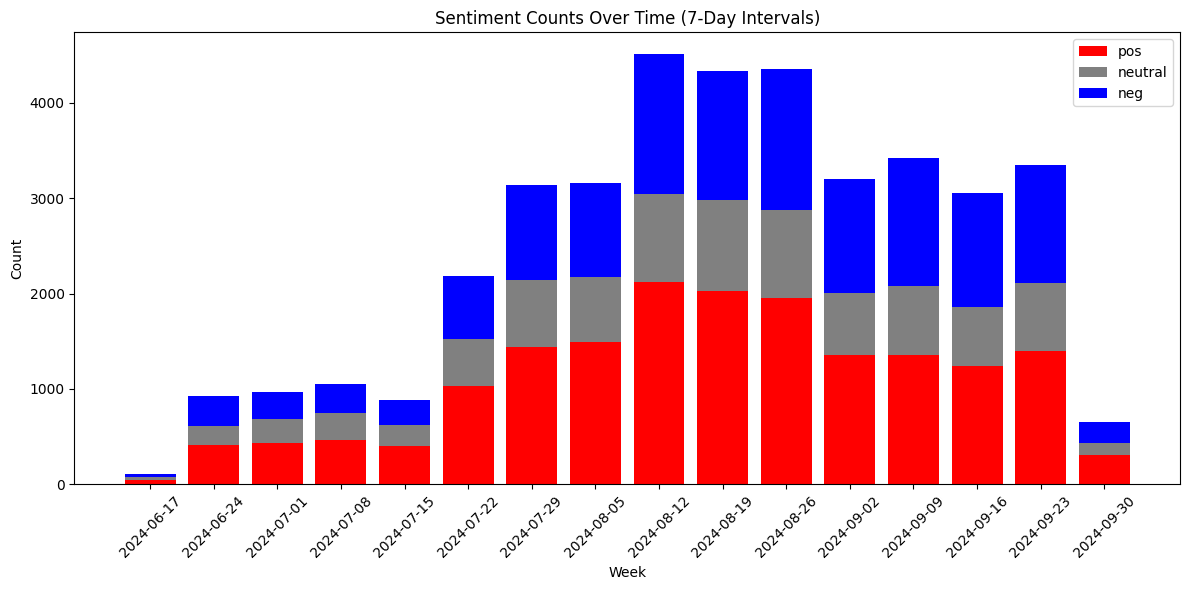

In [27]:
# Filter data to include only rows where the time is in 2024 or later
data['time'] = pd.to_datetime(data['time'], errors='coerce')  
filtered_data = data[data['time'] >= pd.Timestamp('2024-01-01')]

# Group the filtered data by 7-day intervals and count the label occurrences
filtered_data['week'] = filtered_data['time'].dt.to_period('W').apply(lambda r: r.start_time)
grouped = filtered_data.groupby('week')['label'].value_counts().unstack(fill_value=0)

# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))
labels = ['positive', 'neutral', 'negative']
colors = ['red', 'gray', 'blue']

bottom = None
for label, color in zip(labels, colors):
    if bottom is None:
        ax.bar(grouped.index.strftime('%Y-%m-%d'), grouped[label], label=label, color=color)
        bottom = grouped[label]
    else:
        ax.bar(grouped.index.strftime('%Y-%m-%d'), grouped[label], label=label, bottom=bottom, color=color)
        bottom += grouped[label]

# Customize the plot
ax.set_xlabel('Week')
ax.set_ylabel('Count')
ax.set_title('Sentiment Counts Over Time (7-Day Intervals)')
ax.legend(['pos', 'neutral', 'neg'], loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [28]:
from sklearn.model_selection import train_test_split
import numpy as np

# Set a random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

data['split'] = None

# Stratify the split based on the 'label' column
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['label'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['label'], random_state=42)

# Assign split labels
data.loc[train_data.index, 'split'] = 'train'
data.loc[val_data.index, 'split'] = 'val'
data.loc[test_data.index, 'split'] = 'test'

In [29]:
data['split'].value_counts()

split
train    31999
test      6857
val       6857
Name: count, dtype: int64

In [30]:
data.groupby('label')['split'].value_counts()

label     split
negative  train    10735
          test      2301
          val       2300
neutral   train     7040
          val       1509
          test      1508
positive  train    14224
          test      3048
          val       3048
Name: count, dtype: int64

In [31]:
data.to_csv('data_preprocess.csv', index=False)